In [1]:
!sudo chown -R jupyter:jupyter /home/jupyter/Sentiment-Analysis-of-Amazon-Reviews

In [2]:
import os

import pandas as pd
import numpy as np

from argparse import Namespace
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
import sys

sys.path.append('..')
from detectors.tf_gcp.trainer.models.models import CNNModel
from detectors.tf_gcp.trainer.data_ops.data_generator import DataGenerator

In [3]:
PROJECT = 'text-analysis-323506'
REGION = 'us-central1'
BUCKET = 'text-analysis-323506'

In [4]:
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION
os.environ['TFVERSION'] = '2.6'

In [5]:
%%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


In [6]:
train_df = pd.read_csv('../sample_data/train_text.csv')
val_df = pd.read_csv('../sample_data/val_text.csv')

In [7]:
train_df.head()

,input,labels
0,don't waste your time or money!: This movie wi...,1
1,Just walk away: I expected this book to be mor...,1
2,Love mash: Mash is great but why is it a 1-4 C...,1
3,Old Rehashed NFL Films Footage.: I bought this...,1
4,"Satisfied: Good enough. It is indeed snug, and...",0


In [8]:
print(len(train_df), len(val_df))

5000 1000


In [9]:
TOP_K = 20000
MAX_SEQUENCE_LENGTH = 500

In [10]:
tokenizer = Tokenizer(num_words=TOP_K)

In [11]:
lines = list(train_df['input']) + list(val_df['input'])

In [12]:
tokenizer.fit_on_texts(lines)

In [13]:
X_train = tokenizer.texts_to_sequences(list(train_df['input']))
X_val = tokenizer.texts_to_sequences(list(val_df['input']))

In [14]:
X_train = sequence.pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
X_val = sequence.pad_sequences(X_val, maxlen=MAX_SEQUENCE_LENGTH)

In [15]:
y_train = np.array(train_df['labels'])
y_val = np.array(val_df['labels'])

In [16]:
num_features = min(len(tokenizer.word_index) + 1, TOP_K)

In [17]:
Model = CNNModel(num_features=num_features,
                 max_sequence_length=MAX_SEQUENCE_LENGTH).build(Namespace(**{'optimizer': 'adam', 'loss': "binary_crossentropy", 'metrics': ["accuracy"],'embedding_dim': 200}))

[CNNModel::build] Building CNN model


2021-12-11 11:49:32.324626: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [18]:
Model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 200)          4000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 500, 64)           38464     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 250, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 250, 128)          24704     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [19]:
train_generator = DataGenerator(input_text=X_train,
                                        labels=y_train,
                                        batch_size=64)
validation_generator = DataGenerator(input_text=X_val,
                                     labels=y_val,
                                     batch_size=64)

In [20]:
history = Model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=10,
            steps_per_epoch=20,
            workers=5,
            use_multiprocessing=True)

2021-12-11 11:49:33.247815: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
20/20 [==============================] - 9s 428ms/step - loss: 0.6937 - accuracy: 0.4730 - val_loss: 0.6929 - val_accuracy: 0.5040
Epoch 2/10
20/20 [==============================] - 9s 431ms/step - loss: 0.6925 - accuracy: 0.5141 - val_loss: 0.6898 - val_accuracy: 0.6020
Epoch 3/10
20/20 [==============================] - 9s 424ms/step - loss: 0.6825 - accuracy: 0.6168 - val_loss: 0.6667 - val_accuracy: 0.6620
Epoch 4/10
20/20 [==============================] - 8s 404ms/step - loss: 0.6152 - accuracy: 0.6930 - val_loss: 0.5812 - val_accuracy: 0.7110
Epoch 5/10
20/20 [==============================] - 8s 408ms/step - loss: 0.4899 - accuracy: 0.7802 - val_loss: 0.4749 - val_accuracy: 0.7800
Epoch 6/10
20/20 [==============================] - 8s 405ms/step - loss: 0.3662 - accuracy: 0.8554 - val_loss: 0.3982 - val_accuracy: 0.8260
Epoch 7/10
20/20 [==============================] - 10s 482ms/step - loss: 0.2843 - accuracy: 0.8836 - val_loss: 0.3689 - val_accuracy: 0.8400
Epoch

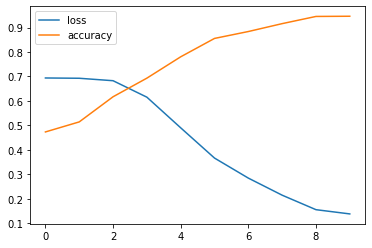

In [21]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.legend()
plt.show()

In [22]:
Model.save('./saved_model')

2021-12-11 11:28:03.353869: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./saved_model/assets


In [23]:
! gsutil -m mv ./saved_model gs://text-analysis-323506-aiplatform

Copying file://./saved_model/keras_metadata.pb [Content-Type=application/octet-stream]...
Copying file://./saved_model/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://./saved_model/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file://./saved_model/variables/variables.index [Content-Type=application/octet-stream]...
Removing file://./saved_model/saved_model.pb...                                 
Removing file://./saved_model/keras_metadata.pb...                              
Removing file://./saved_model/variables/variables.index...                      
Removing file://./saved_model/variables/variables.data-00000-of-00001...        
- [4/4 files][ 46.7 MiB/ 46.7 MiB] 100% Done                                    
Operation completed over 4 objects/46.7 MiB.                                     


### Create model endpoint

In [32]:
os.environ['MODEL_DIR']="gs://text-analysis-323506-aiplatform/saved_model"
os.environ['VERSION_NAME']="V1"
os.environ['MODEL_NAME']="sentiment_analyser"
os.environ['FRAMEWORK']="tensorflow"
os.environ['INPUT_DATA_FILE']="./input.json"

In [28]:
%%bash

gcloud ai-platform models create $MODEL_NAME --region=$REGION --enable-logging

Using endpoint [https://us-central1-ml.googleapis.com/]
Created ai platform model [projects/text-analysis-323506/models/sentiment_analyser2].


In [25]:
%%bash
gcloud ai-platform versions create $VERSION_NAME \
  --model=$MODEL_NAME \
  --origin=$MODEL_DIR \
  --runtime-version=2.6 \
  --framework=$FRAMEWORK \
  --python-version=3.7 \
  --region=$REGION \
  --machine-type=n1-standard-2 \
  --user-output-enabled

Using endpoint [https://us-central1-ml.googleapis.com/]
Creating version (this might take a few minutes)......
.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [26]:
test_df = pd.read_csv('../sample_data/test_text_100.csv')

In [27]:
test_df.head()

,input,labels
0,Great CD: My lovely Pat has one of the GREAT v...,0
1,One of the best game music soundtracks - for a...,0
2,Batteries died within a year ...: I bought thi...,1
3,"works fine, but Maha Energy is better: Check o...",0
4,Great for the non-audiophile: Reviewed quite a...,0


In [28]:
X_test = tokenizer.texts_to_sequences(list(test_df['input']))
X_test = sequence.pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)

In [46]:
for value in X_test[:10]:
    prediction = Model.predict(np.array([value]))
    print(prediction)

[[0.13463295]]
[[0.0002774]]
[[0.95587695]]
[[0.31515345]]
[[0.10683462]]
[[0.93513846]]
[[0.99217236]]
[[0.7323654]]
[[0.27761]]
[[0.44422027]]


In [41]:
json_entry = {"instances":
                 [{"input": [int(value) for value in test_value]} for test_value in X_test[:10]]}

In [42]:
import json
with open('input.json', 'w') as f:
    json.dump(json_entry, f)

In [43]:
%%bash
gcloud ai-platform predict \
  --model=$MODEL_NAME \
  --version=$VERSION_NAME \
  --json-request=$INPUT_DATA_FILE \
  --region=$REGION

[[0.134632856], [0.000277370214], [0.955876946], [0.315153539], [0.10683468], [0.935138464], [0.99217236], [0.732365429], [0.27761], [0.444220275]]


Using endpoint [https://us-central1-ml.googleapis.com/]
